# 로봇 인공지능 만들기 Assignment 4

서울대학교 기계항공공학부 2013-11815 이승섭

## 2. Annotate W05-3 example code
Connect equations with code.

### 2.1. Body Temperature Measurement
Temperature measurement: X = [x], A = [1], H = [1], $w \sim N(0,0.5^{2}), v \sim N(0,1.1^{2})$. 

$$X = AX+w, Z=HX+v$$

In [1]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

%matplotlib inline

In [2]:
# Define Kalman filter functions

def kf_predict(X,P,A,Q,B,U):
    '''
    Based on the previous posterior X and P estimates, calculate the new prior estimates for the next time step.
    x_prior = Ax_posterior + Bu, P_prior = APA^T + Q
    '''
    X_new = np.dot(A,X) + np.dot(B,U)
    P_new = np.dot(A, np.dot(P, A.T)) + Q
    return(X_new,P_new)

def kf_update(X,P,Z,H,R):
    '''
    Based on the prior estimates and the new measurement Z, calculate the new posterior estimates.
    K = PH^T(HPH^T + R)^-1, x_posterior = x_prior + K(Z - Hx_prior), P_posterior = (I - KH)P_prior
    '''
    K = np.dot(P, np.dot(H.T, inv(np.dot(H, np.dot(P, H.T)) + R)))
    X_new = X + np.dot(K, (Z - np.dot(H,X)))
    P_new = P - np.dot(K, np.dot(H,P))
    return(X_new,P_new,K)

In [3]:
# Define initial states

# Uncertain severity of process noise
pn = 0.5
# Uncertain severity of measurement noise
sn = 1.1

# State matrices
X = np.array([0.0]) # Initial state
P = np.array([0.1]) # Initial covariance matrix
A = np.array([1]) # State transition matrix
Q = pn**2 * np.eye(X.shape[0]) # Process noise covariance matrix
B = np.zeros(A.shape) # Control input matrix
U = np.zeros((X.shape[0],1)) # Control input

# Measurement matrices
H = np.array([1]) # Measurement matrix
Z = np.array([X[0] + sn * np.random.randn(1)[0]]) # Measurement
R = sn ** 2 * np.eye(Z.shape[0]) # Measurement noise covariance matrix


In [4]:
# Iterate over 200 time steps

iteration = 200
x_plot = []
y_plot_x0 = []
y_plot_z0 = []

for i in np.arange(iteration):
    # Predict
    X,P = kf_predict(X,P,A,Q,B,U) # Predict the next state
    
    # Update
    Z = np.array([36.5 + sn * np.random.randn(1)[0]]) # Update the measurement
    X,P,K = kf_update(X,P,Z,H,R) # Update the state based on the measurement
    
    # Store the results
    x_plot.append(i)
    y_plot_x0.append(X[0])
    y_plot_z0.append(Z[0])

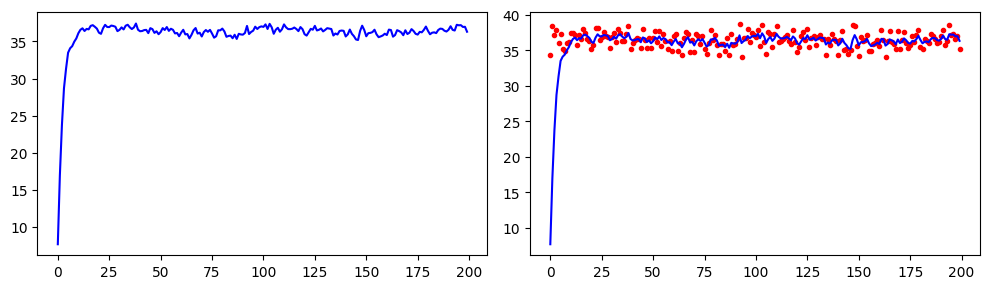

In [5]:
# Estimate and plot from zero knowledge

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(x_plot, y_plot_x0, 'b-', alpha = 1)
ax2.plot(x_plot, y_plot_z0, 'r.')
ax2.plot(x_plot, y_plot_x0, 'b-', alpha = 1)
fig.tight_layout()
plt.show()

### 2.2 GPS Localization in free-fall

$y'' = -9.8m/s$, $X = AX+BU+w$, $Z = HW+v$ where $w\sim N(0,1^{2}), v\sim N(0,10^{2})$.

In [6]:
# Libraries and functions are already defined in the previous cells

# Define initial states

# Time step
dt = 0.1
# Uncertain severity of process noise
pn = 0.5
# Uncertain severity of measurement noise
sn = 10

# State matrices
X = np.array([[0.0], [0.0], [0], [0]]) # Initial state
P = np.diag([0.1, 0.1, 0.1, 0.1]) # Initial covariance matrix
A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]]) # State transition matrix
Q = pn**2 * np.eye(X.shape[0]) # Process noise covariance matrix
B = np.array([[0.5*dt**2, 0], [0, 0.5*dt**2], [dt, 0], [0, dt]]) # Control input matrix
U = np.array([[0.0], [-9.8]]) # Control input

# Measurement matrices
Z = np.zeros(4)
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]) # Measurement matrix
R = sn ** 2 * np.eye(Z.shape[0]) # Measurement noise covariance matrix

In [7]:
# Iterate over 50 time steps

iteration = 50
real_y_vel = 0
real_y_pos = 0

x_plot = []
y_plot_x0 = []
y_plot_z0 = []
y_plot_r0 = []

for i in np.arange(iteration):
    (X, P) = kf_predict(X, P, A, Q, B, U) # Predict the next state
    
    # Compute theoretical measurements
    real_y_vel = -9.8 * i * dt
    real_y_pos = 0.5 * -9.8 * (i*dt)**2
    
    # Update measurements
    
    Z = np.array([[0 + sn * np.random.randn(1)[0]], [real_y_pos + sn * np.random.randn(1)[0]], [0 + sn * np.random.randn(1)[0]], [real_y_vel + sn * np.random.randn(1)[0]]]) # Update the measurements (x_pos, y_pos, x_vel, y_vel)
    
    (X, P, K) = kf_update(X, P, Z, H, R) # Update the state based on the measurements
    
    # Store the results
    x_plot.append(i)
    y_plot_x0.append(X[1,0])
    y_plot_z0.append(Z[1,0])
    y_plot_r0.append(real_y_pos)

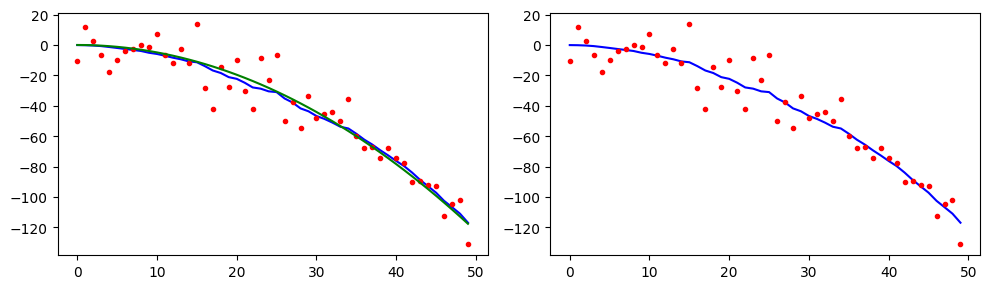

In [8]:
# Estimate and plot from zero knowledge

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(x_plot, y_plot_x0, 'b-', alpha = 1)
ax1.plot(x_plot, y_plot_z0, 'r.')
ax1.plot(x_plot, y_plot_r0, 'g-', alpha = 1)

ax2.plot(x_plot, y_plot_x0, 'b-', alpha = 1)
ax2.plot(x_plot, y_plot_z0, 'r.')

fig.tight_layout()
plt.show()

## 3. Graph Denoised Prices for Intel Corporation Common Stock (INTC)

I used yfinance library to download stock prices.

In [9]:
# Import required libraries
import yfinance as yf
import pandas as pd

In [10]:
# Download data and save it to a CSV file

ticker = 'INTC'
data = yf.download(ticker, start="2023-01-01", end="2024-01-01", interval = "1d")

data.to_csv('intel_stock_data.csv')

df = pd.read_csv('intel_stock_data.csv', index_col = 'Date', parse_dates = True)

[*********************100%***********************]  1 of 1 completed


In [11]:
# Get only closing prices and visualize data

df = df[['Close']].values

In [12]:
# Functions are already defined in the previous cells

# Define initial states

# Time step
iterations = df.shape[0]

# Uncertain severity of process noise - set to low value
pn = 0.001

# Uncertain severity of measurement noise - set to higher value
sn = 1

# State matrices
X = np.array([[df[0][0]], [0.0]]) # Initial state (price, price change rate)
P = np.eye(2) # Initial covariance matrix
A = np.array([[1, 1], [0, 1]]) # State transition matrix
Q = pn**2 * np.eye(X.shape[0]) # Process noise covariance matrix
B = np.zeros(A.shape) # Control input matrix
U = np.zeros((X.shape[0],1)) # Control input

# Measurement Matrices
Z = np.array([[df[i][0] + sn * np.random.randn(1)[0]]]) # Measurement
H = np.array([[1, 0]]) # Measurement matrix
R = sn ** 2 * np.eye(1) # Measurement noise covariance matrix


In [13]:
# Iterate over days

x_plot = []
y_plot_x0 = []
y_plot_z0 = []
y_plot_r0 = []

for i in np.arange(iterations):
    # Predict
    (X, P) = kf_predict(X, P, A, Q, B, U) # Predict the next state
    
    # Add actual value
    y_plot_r0.append(df[i][0])
    
    # Update
    Z = np.array([[df[i][0] + sn * np.random.randn(1)[0]]]) # Update the measurement
    (X, P, K) = kf_update(X, P, Z, H, R) # Update the state based on the measurement
    
    # Store the results
    x_plot.append(i)
    y_plot_x0.append(X[0,0])
    y_plot_z0.append(Z[0,0])

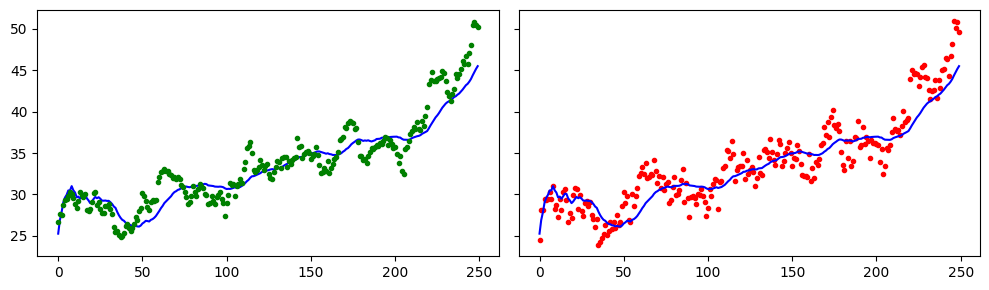

In [ ]:
# Estimate and plot from zero knowledge

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey = True)
ax1.plot(x_plot, y_plot_x0, 'b-', alpha = 1)
ax1.plot(x_plot, y_plot_r0, 'g.')
ax2.plot(x_plot, y_plot_z0, 'r.')
ax2.plot(x_plot, y_plot_x0, 'b-', alpha = 1)
fig.tight_layout()
plt.show()